In [5]:
# from keras.preprocessing.image import ImageDataGenerator

# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import json
import bz2
import urllib.parse
import pandas as pd
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.3.0


In [9]:
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

Num GPUs Available: 2


Functions to be put in helpfile

In [79]:
def get_y_true(samples, class_indices, classes):
    y_true = np.zeros((samples, len(class_indices))) # nr_rows=nr_images; nr_columns=nr_classes
    for row_idx, row in enumerate(classes):
        for idx in row:
            y_true[row_idx, idx] = 1
    return y_true

# def get_y_true(classes, preset_nr_classes=0):
#     """Gets one-hot encoded matrix of format (nr_images)x(nr_classes)."""
#     nr_images = len(classes)
#     if not preset_nr_classes:
#         nr_classes = len(set([item for sublist in classes for item in sublist]))
#     else:
#         nr_classes = preset_nr_classes
#     y_true = np.zeros((nr_images, nr_classes))
#     for row_idx, row in enumerate(classes):
#         for idx in row:
#             y_true[row_idx, idx] = 1
#     return y_true

def balance_test(classes, class_names, test_df):
        """ 
        Constructs a sort of more balanced test set in a dummy way by adding to it only the images that contain 
        the - for the moment - most uncommon class.
        Inputs:
            - classes: [[]]
            - class_names: list with all labels: 
            - test_df: dataframe with rows containing image files and labels
        """
        y_true = get_y_true(classes)
        sorted_indices = np.argsort(np.sum(y_true, axis=0))
        sorted_class_names = np.array(list(class_names))[sorted_indices]
        least_common_class = sorted_class_names[0]
        balanced_classes = []
        row_ids = []
        counter = 0 
        for index, row in test_df.iterrows():
            counter += 1
            if counter % 10 == 0:
                y_true = get_y_true(balanced_classes, 40)
                sorted_indices = np.argsort(np.sum(y_true, axis=0))
                sorted_class_names = np.array(class_names)[sorted_indices]
                least_common_class = sorted_class_names[0]
            if least_common_class in row.labels:
                balanced_classes.append(row.labels)
                row_ids.append(index)

        return test_df.loc[row_ids, :]
    
def plot_distribution(classes, class_names=[], description='None', plot_log=False, lims=()):
    y_true = get_y_true(classes)
    sorted_indices = np.argsort(np.sum(y_true, axis=0))
    sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]
    plt.figure(figsize=(12, 15))
    plt.title('Number of images per class' + description)
    if plot_log:
        plt.xscale('log')
    if lims:
        plt.xlim(lims)
    plt.xlabel('Count')
    plt.grid(True)
    plt.barh(np.array(range(y_true.shape[1])), sorted_images_per_class, color='blue', alpha=0.65)
    if class_names:
        plt.yticks(range(y_true.shape[1]), np.array(list(class_names))[sorted_indices])


### Hyperparameters

In [76]:
from PIL import PngImagePlugin  

EPOCHS = 15
IMAGE_DIMENSION = 64
MINIMAL_NR_IMAGES = 1_000
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2) # to avoid corrupted .png images

## 1. Read, clean and split data

### Import data

In [29]:
NAIVE_LABELS_PATH = 'data/commonswiki-20220220-files-naive-labels.json.bz2'
naive_labels = pd.read_json(NAIVE_LABELS_PATH)

# With this "better_url" only 190k images aren't found, while with "url" 790k aren't found
naive_labels['url'] = naive_labels['url'].apply(lambda encoded_filename : urllib.parse.unquote(encoded_filename).encode().decode('unicode-escape'))
naive_labels['can_be_opened'] = naive_labels['url'].apply(lambda url : os.path.isfile('/scratch/WIT_Dataset/images/' + url))
naive_labels.rename(columns={'new_labels': 'labels'}, inplace=True)
print(f'Total number of files: {naive_labels.shape[0]}.')

# Only keep the files that can be opened
naive_labels = naive_labels.loc[naive_labels.can_be_opened == True].reset_index(drop=True)

print(f'Total number of files that can be opened: {naive_labels.shape[0]}.')

print(naive_labels.shape)
naive_labels.head()

Total number of files: 2008312.
Total number of files that can be opened: 1817975.
(1817975, 6)


,id,title,url,categories,labels,can_be_opened
0,74785910,"""Carnevale di Torino"". Felice Cerruti - f.lli ...","1/13/""Carnevale_di_Torino""._Felice_Cerruti_-_f...","[Felice Cerruti Bauduc, Victor Emmanuel II of ...","[Places, Society]",True
1,14890941,"""Escena de playa con figura"".jpg","c/c2/""Escena_de_playa_con_figura"".jpg","[Pedro Lira, People with dogs in art]","[Culture, Entertainment]",True
2,17073242,"""Mary Holiday"" - NARA - 559051.jpg","0/02/""Mary_Holiday""_-_NARA_-_559051.jpg","[Art of the United States, Harmon Foundation, ...","[Culture, History, Society]",True
3,5259480,"""The End of the 'Forty Five' Rebellion"".jpg","c/c7/""The_End_of_the_'Forty_Five'_Rebellion"".jpg","[Battle of Culloden, 1882 engravings, Wounded ...","[Culture, History]",True
4,67898619,"""Woman are too sentimental for jury duty"" -Ant...","f/f0/""Woman_are_too_sentimental_for_jury_duty""...","[Pro-suffrage cartoons, Kenneth R. Chamberlain...","[Culture, Politics, Society]",True


### Remove classes with less than $10^4$ images

In [30]:
_generator = ImageDataGenerator() 
_data = _generator.flow_from_dataframe(dataframe=naive_labels, 
                                       directory='/scratch/WIT_Dataset/images', 
                                       x_col='url', 
                                       y_col='labels', 
                                       class_mode='categorical', 
                                       validate_filenames=False)

y_true = get_y_true(_data.samples, _data.class_indices, _data.classes)

Found 1817975 non-validated image filenames belonging to 42 classes.


Plot distribution of images per category.

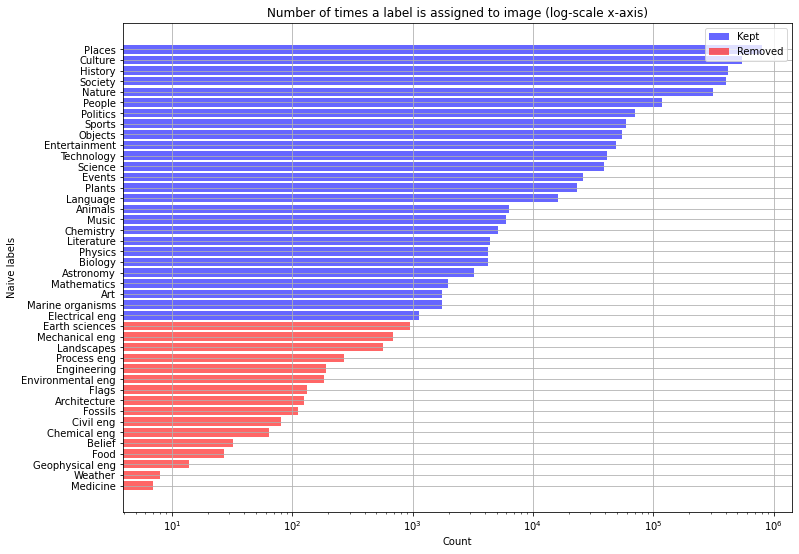

In [31]:
sorted_indices = np.argsort(np.sum(y_true, axis=0))
sorted_images_per_class = y_true.sum(axis=0)[sorted_indices]

mask_kept = y_true.sum(axis=0)[sorted_indices] > MINIMAL_NR_IMAGES
mask_removed = y_true.sum(axis=0)[sorted_indices] < MINIMAL_NR_IMAGES

_ = plt.figure(figsize=(12, 9))
_ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')

_ = plt.barh(np.array(range(y_true.shape[1]))[mask_kept], sorted_images_per_class[mask_kept], color='blue', alpha=0.6)
_ = plt.barh(np.array(range(y_true.shape[1]))[mask_removed], sorted_images_per_class[mask_removed], color='red', alpha=0.6)

_ = plt.yticks(range(y_true.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices])
_ = plt.xscale('log')
_ = plt.xlabel('Count')
_ = plt.ylabel('Naive labels')
_ = plt.grid(True)

plt.legend(['Kept', 'Removed'], loc='upper right')

Now, remove these labels from the naive_labels, and remove the images that were only belonging to these labels from the naive_labels dataframe.

In [32]:
indices_of_classes_to_remove = np.where(np.sum(y_true, axis=0) < MINIMAL_NR_IMAGES)
classes_to_remove = np.array(list(_data.class_indices.keys()))[indices_of_classes_to_remove]

naive_labels['labels'] = naive_labels['labels'].apply(lambda labels: [el for el in labels if el not in classes_to_remove])
naive_labels_clean = naive_labels[naive_labels['labels'].str.len() != 0]
print(f'Removed {naive_labels.shape[0] - naive_labels_clean.shape[0]} images that were only labeled as the removed labels. Left with {naive_labels_clean.shape[0]/1e6:.2f} M images.')

Removed 774 images that were only labeled as the removed labels. Left with 1.82 M images.


### Split data and create generators with augmentations

In [33]:
from sklearn.model_selection import train_test_split
split = False

if split:
    train_df, test_df = train_test_split(naive_labels_clean, test_size=0.05, random_state=17)

    print(f'Train set: {train_df.shape[0]} images ({train_df.shape[0] / naive_labels.shape[0]:.2f}%)')
    print(f'Test set:  {test_df.shape[0]}  images ({test_df.shape[0] / naive_labels.shape[0]:.2f}%)')

    train_df.to_json('data/splitted_dfs_20220528/train_df.json.bz2', compression='bz2')
    test_df.to_json('data/splitted_dfs_20220528/test_df.json.bz2', compression='bz2')
else:
    train_df = pd.read_json('data/splitted_dfs_20220528/train_df.json.bz2', compression='bz2')
    test_df = pd.read_json('data/splitted_dfs_20220528/test_df.json.bz2', compression='bz2')

Train set: 1726340 images (0.95%)
Test set:  90861  images (0.05%)


Divide dataset into train and validation sets

In [88]:
# Data generator for training and validation sets, performs data augmentations
train_generator = ImageDataGenerator(validation_split=0.05, 
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest') 

print('\n----------- Train images -----------')
train = train_generator.flow_from_dataframe(dataframe=train_df, 
                                            directory='/scratch/WIT_Dataset/images', 
                                            x_col='url', 
                                            y_col='labels', 
                                            class_mode='categorical',
                                            subset='training',
                                            batch_size=32,
                                            validate_filenames=True,
                                            target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

print('\n----------- Validation images -----------')          
val = train_generator.flow_from_dataframe(dataframe=train_df, 
                                          directory='/scratch/WIT_Dataset/images', 
                                          x_col='url', 
                                          y_col='labels', 
                                          class_mode='categorical',
                                          subset='validation',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))

# Data generator for test set
test_generator = ImageDataGenerator() 
print('\n----------- Test images -----------')          
test = test_generator.flow_from_dataframe(dataframe=test_df,
                                          directory='/scratch/WIT_Dataset/images',
                                          x_col='url', 
                                          y_col='labels', 
                                          class_mode='categorical',
                                          validate_filenames=True,
                                          target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))


----------- Train images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 8286 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


Found 1632152 validated image filenames belonging to 26 classes.

----------- Validation images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 8286 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


Found 85902 validated image filenames belonging to 26 classes.

----------- Test images -----------


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 439 invalid image filename(s) in x_col="url". These filename(s) will be ignored.
  warnings.warn(


Found 90422 validated image filenames belonging to 26 classes.


### 2. Construct and train model
Here, we construct a model where the first layers are EfficientNetB0 pre-trained on ImageNet-1k(https://keras.io/api/applications/efficientnet/) with added layers to the end, and train these final end layers with our training data.

In [91]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

N_LABELS = len(train.class_indices)

def create_model():
    """Take efficientnet pre-trained on imagenet-1k, not including the last layer."""
    efficient_net = EfficientNetB0(include_top=False, 
                                   weights='imagenet', 
                                   classes=N_LABELS,
                                   input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3))
    efficient_net.trainable=False

    model = Sequential([
        efficient_net,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(N_CLASSES, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

model = create_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 2, 2, 1280)        4049571   
_________________________________________________________________
flatten_1 (Flatten)          (None, 5120)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               655488    
_________________________________________________________________
dense_3 (Dense)              (None, 26)                3354      
Total params: 4,708,413
Trainable params: 658,842
Non-trainable params: 4,049,571
_________________________________________________________________


In [86]:
# y_true = get_y_true(train.samples, train.class_indices, train.classes)

# def compute_class_weights(y_true):
#     """
#     Computes class_weights to compensate imbalanced classes. Inspired in 
#     'https://towardsdatascience.com/dealing-with-imbalanced-data-in-tensorflow-class-weights-60f876911f99'.
#     Dictionary mapping class indices (integers) to a weight (float) value, 
#     used for weighting the loss function (during training only).
#     """
#     class_count = y_true.sum(axis=0)
#     n_samples = y_true.shape[0] 
#     n_classes = y_true.shape[1]

#     # Compute class weights using balanced method
#     class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
#     class_labels = range(len(class_weights))
#     return dict(zip(class_labels, class_weights))

# class_weights = compute_class_weights(y_true)#dict(enumerate(y_true.sum().sum() / y_true.sum(axis=0)))
# print(class_weights)

In [ ]:
# Save the weights using the `checkpoint_path` format
checkpoint_path = "checkpoints/naive_26_labels_no_weights_20220528/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
model.save_weights(checkpoint_path.format(epoch=0))

history = model.fit(train, 
                    epochs=EPOCHS, 
                    validation_data=val,
                    verbose=1,
                    callbacks=[cp_callback],
                    # class_weight=class_weights,
                   )
                    

Epoch 1/15
  247/51005 [..............................] - ETA: 6:49:57 - loss: 0.1725 - accuracy: 0.2661

Plot training vs validation accuracy and loss

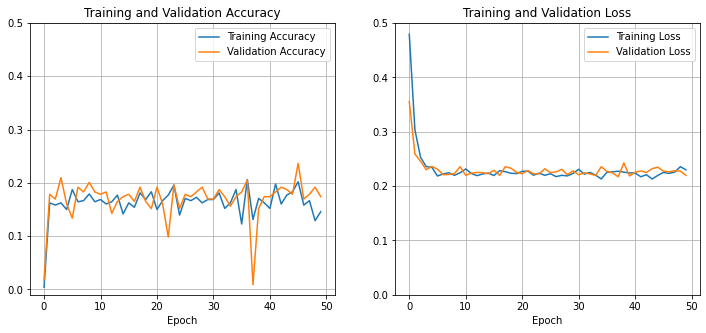

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

cat_acc = history.history['categorical_accuracy']
val_cat_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Epoch')
plt.ylim(-0.01, 0.5)
plt.grid(True)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, cat_acc, label='Training Accuracy')
plt.plot(epochs_range, val_cat_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Categorical Accuracy')

plt.subplot(1, 2, 2)
plt.xlabel('Epoch')
plt.ylim(0, 0.5)
plt.grid(True)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3. Evaluation metrics
Here, we evaluate the trained model on the test set and take out classification metrics (precision & recall) for each of the individual 64 classes.

In [70]:
# y_true_test = get_y_true(test.samples, test.class_indices, test.classes)

# sorted_indices = np.argsort(np.sum(y_true_test, axis=0))
# sorted_images_per_class = y_true_test.sum(axis=0)[sorted_indices]

# # mask_kept = y_true.sum(axis=0)[sorted_indices] > MINIMAL_NR_IMAGES
# # mask_removed = y_true.sum(axis=0)[sorted_indices] < MINIMAL_NR_IMAGES

# _ = plt.figure(figsize=(12, 15))
# _ = plt.title('Number of times a label is assigned to image (log-scale x-axis)')

# _ = plt.barh(np.array(range(y_true_test.shape[1])), sorted_images_per_class, color='blue', alpha=0.6)
# # _ = plt.barh(np.array(range(y_true.shape[1])), sorted_images_per_class, color='red', alpha=0.6)

# _ = plt.yticks(range(y_true_test.shape[1]), np.array(list(_data.class_indices.keys()))[sorted_indices])
# _ = plt.xscale('log')
# _ = plt.xlabel('Count')
# _ = plt.grid(True)
# balance_test(test.classes, list(test.class_indices.keys()), test_df)
# classes = test.classes
# class_names = list(test.class_indices.keys())

# y_true = get_y_true(classes)

# sorted_indices = np.argsort(np.sum(y_true, axis=0))
# sorted_class_names = np.array(list(class_names))[sorted_indices]
# least_common_class = sorted_class_names[0]
# balanced_classes = []
# row_ids = []

# counter = 0 
# for index, row in test_df.iterrows():
#     counter += 1
#     print(counter)
#     if counter % 10 == 0:
#         print(f'hej{balanced_classes}')
#         y_true = get_y_true(balanced_classes, 40)
#         print(y_true)
#         sorted_indices = np.argsort(np.sum(y_true, axis=0))
# #         print(sorted_indices)
#         sorted_class_names = np.array(class_names)[sorted_indices]
#         least_common_class = sorted_class_names[0]
#     if least_common_class in row.labels:
#         balanced_classes.append(row.labels)
#         row_ids.append(index)

# test_df.loc[row_ids, :]

In [5]:
IMAGE_DIMENSION = 64
test_df = pd.read_json('data/test_df.json.bz2', compression='bz2')
test_generator = ImageDataGenerator(rescale=1/255) 
test = test_generator.flow_from_dataframe(dataframe=test_df, directory='/scratch/WIT_Dataset/images',
                                                  x_col='image_path', y_col='taxo_labels', 
                                                  class_mode='categorical', validate_filenames=True,
                                                  target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))


/home/matvieir/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 15694 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 86423 validated image filenames belonging to 40 classes.


In [3]:
model = tf.keras.models.load_model('saved_model/my_model')

In [6]:
predictions = model.predict(test)

/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
predictions

array([[0.25024658, 0.0389429 , 0.01601201, ..., 0.23332831, 0.0126566 ,
        0.0201067 ],
       [0.25054488, 0.03894585, 0.01600251, ..., 0.23355052, 0.01266322,
        0.02005428],
       [0.25082082, 0.03893194, 0.01597461, ..., 0.23321131, 0.01266599,
        0.02014324],
       ...,
       [0.2506966 , 0.03900784, 0.01602477, ..., 0.23370165, 0.0126873 ,
        0.02007321],
       [0.25063866, 0.03892347, 0.0159682 , ..., 0.23319528, 0.01264963,
        0.02010173],
       [0.2506582 , 0.03898385, 0.01597679, ..., 0.23311535, 0.01264817,
        0.02009624]], dtype=float32)

In [13]:
threshold = 0.2
y_pred = 1 * (predictions > threshold)
# with open('checkpoints/y_pred', 'rb') as f:
#     y_pred = np.load(f) 

In [15]:
print(y_pred)

[[1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 ...
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]]


In [16]:
# Transform 'test.classes' to a one-hot encoded matrix, y_true
y_true = np.zeros(y_pred.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true[row_idx, idx] = 1

Make predictions on the test set and then get classification metrics

In [21]:
from sklearn.metrics import average_precision_score, accuracy_score, roc_auc_score

# micro, samples, weighted, macro
# accuracy_score(y_true, y_pred)
roc_auc_score(y_true, y_pred)


0.5

In [22]:
from sklearn.metrics import classification_report
N_CLASSES = y_true.shape[1]
metrics_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=list(test.class_indices), output_dict=True)).transpose()
metrics_df['index'] = np.concatenate((np.arange(start=0, stop=N_CLASSES), [None, None, None, None]))
metrics_df

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,index
Culture.Biography.Biography*,0.260232,1.000000,0.412990,22490.0,0
Culture.Biography.Women,0.000000,0.000000,0.000000,3605.0,1
Culture.Food and drink,0.000000,0.000000,0.000000,1133.0,2
Culture.Literature,0.000000,0.000000,0.000000,1905.0,3
Culture.Media.Media*,0.000000,0.000000,0.000000,5886.0,4
Culture.Media.Music,0.000000,0.000000,0.000000,2931.0,5
Culture.Philosophy and religion,0.000000,0.000000,0.000000,3201.0,6
Culture.Sports,0.000000,0.000000,0.000000,7307.0,7
Culture.Visual arts.Architecture,0.000000,0.000000,0.000000,5371.0,8
Culture.Visual arts.Visual arts*,0.000000,0.000000,0.000000,7965.0,9


Precision & recall metrics for each class

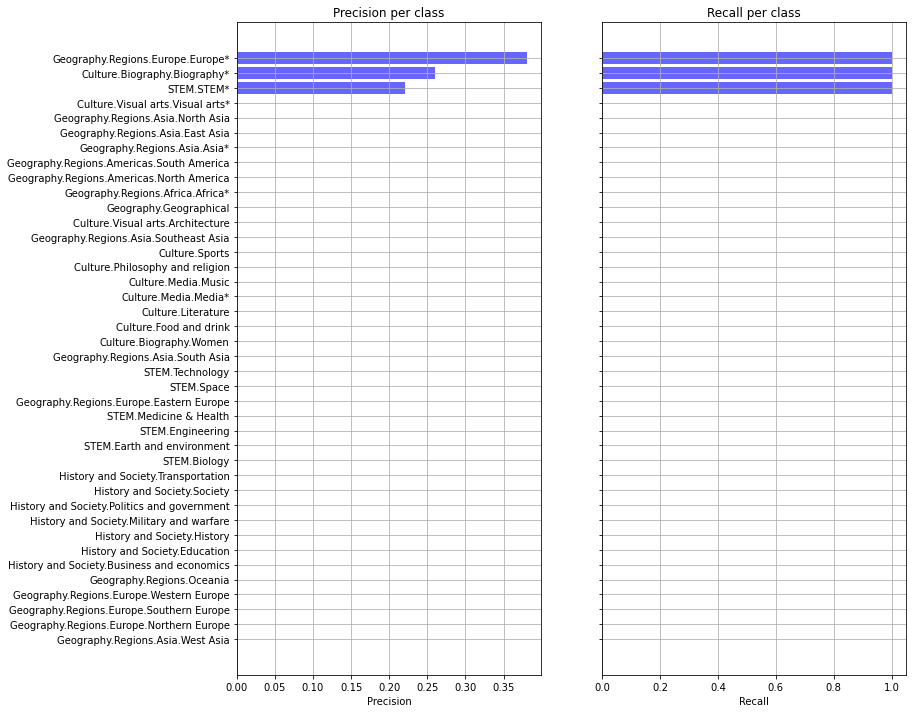

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))

# Precision
sorted_indices_precision = np.argsort(metrics_df.precision[0:N_CLASSES])
sorted_precisions_per_class = metrics_df.precision[0:N_CLASSES][sorted_indices_precision]
# Recall
sorted_indices_recall = np.argsort(metrics_df.recall[0:N_CLASSES])
sorted_recalls_per_class = metrics_df.recall[0:N_CLASSES][sorted_indices_recall]

axs[0].set_title('Precision per class')
axs[0].barh(range(y_true.shape[1]), sorted_precisions_per_class, color='blue', alpha=0.6)
axs[0].set_yticks(range(N_CLASSES))
axs[0].set_yticklabels(np.array(list(test.class_indices.keys()))[sorted_indices_precision])
axs[0].set_xlabel('Precision')
axs[0].grid(True)


axs[1].set_title('Recall per class')
axs[1].barh(range(y_true.shape[1]), sorted_recalls_per_class, color='blue', alpha=0.6)
axs[1].set_yticks(range(N_CLASSES))
axs[1].set_yticklabels([])
axs[1].set_xlabel('Recall')
axs[1].grid(True)